In [1]:
from tensorflow.keras import layers, Model, metrics, optimizers
from tensorflow.random import set_seed
import numpy as np
from matplotlib import pyplot as plt

# to make the reproducible results
set_seed(1)
np.random.seed(1)

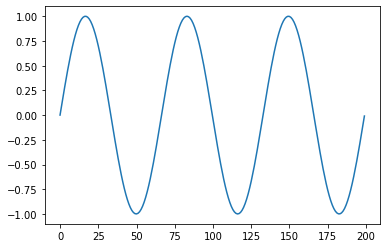

In [2]:
# create a sine wave from 0 to 6π including 200 points 
data = np.sin(np.linspace(0, 6*3.14, 200)) 
plt.plot(data);plt.show()

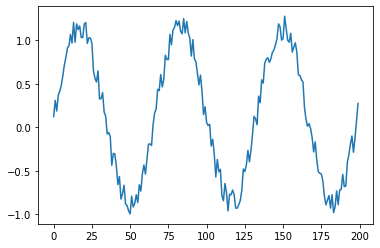

In [3]:
# add some noise
data = data + 0.3 * np.random.random(data.shape)
plt.plot(data);plt.show()

In [4]:
# create time series data
number_of_total_samples = data.size
window_size = 20

X = []
Y = []

for i in range(window_size, number_of_total_samples):
    X.append(data[i - window_size: i])
    Y.append(data[i])

X = np.array(X)
Y = np.array(Y)

#number of training samples : number_of_total_samples - window_size
print(f"{X.shape=}, {Y.shape=}")

X.shape=(180, 20), Y.shape=(180,)


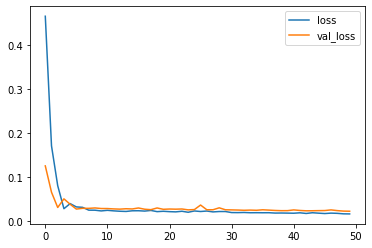

In [5]:
# create model 
def get_model():
    inp = layers.Input(X[0].shape)
    x = layers.Dense(1)(inp)
    model = Model(inp, x)
    model.compile(optimizer=optimizers.Adam(0.01), loss='mse')
    return model 

model = get_model()

hist = model.fit(x=X, y=Y, validation_split=0.1, epochs=50, verbose=0)

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(); plt.show()

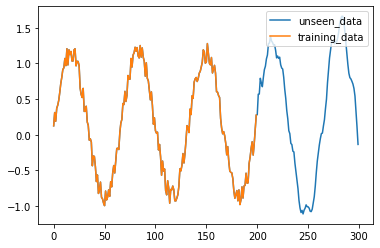

In [8]:
# test on unseen data
new_data = data.copy()
horizon = 100

for i in range(horizon):
    pred = model.predict(np.array([new_data[-window_size:]]))
    new_data = np.append(new_data, pred[0])

plt.plot(new_data, label='unseen_data')
plt.plot(data, label='training_data')
plt.legend(loc='upper right');plt.show()

In [9]:
# save keras model to disk 
model.save("sine_predictor_model.h5")
!ls -lh

total 100K
-rw-r--r-- 1 sajad sajad  67K May 31 17:44 001_tensorflow_serving.ipynb
-rw-r--r-- 1 sajad sajad 8.5K May 31 17:41 note
-rw-r--r-- 1 sajad sajad  19K May 31 17:50 sine_predictor_model.h5


In [11]:
# convert keras model to tensorflow model

from pathlib import Path
import tensorflow as tf

model = tf.keras.models.load_model("sine_predictor_model.h5")
tf_model_dir = "models/sine_predictor/1/"
Path(tf_model_dir).mkdir(exist_ok=True, parents=True)
tf.saved_model.save(model, export_dir=tf_model_dir)
!ls -lh


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/sine_predictor/1/assets
total 136K
-rw-r--r-- 1 sajad sajad  98K May 31 17:58 001_tensorflow_serving.ipynb
drwxr-xr-x 3 sajad sajad 4.0K May 31 17:56 models
-rw-r--r-- 1 sajad sajad 8.5K May 31 17:41 note
-rw-r--r-- 1 sajad sajad  19K May 31 17:50 sine_predictor_model.h5


------------------------------------
# now run this command in terminal to launch server on a container
```
docker run -t --rm -p 8501:8501 \
    -v "$(pwd)/models:/models/" \
    -e MODEL_NAME=sine_predictor \
    --name sine_predictor_server \
    tensorflow/serving:2.5.1
```

In [12]:
# show the result of a single sample
sample = [new_data[-window_size:]]
pred = model.predict(np.array(sample))
print("sample: ", list(sample[0]))
print("label: ", pred)

sample:  [1.4378031492233276, 1.5617845058441162, 1.6172891855239868, 1.6590237617492676, 1.6608054637908936, 1.5965698957443237, 1.4546186923980713, 1.2914475202560425, 1.1424000263214111, 0.9873566031455994, 0.8619832396507263, 0.8001081347465515, 0.7817807793617249, 0.748512327671051, 0.7103311419487, 0.6486642360687256, 0.5413203835487366, 0.3300325870513916, 0.10920374095439911, -0.13580568134784698]
label:  [[-0.35706243]]


In [13]:
# test the server by python requests
import requests

res = requests.post(
    "http://localhost:8501/v1/models/sine_predictor:predict",
    json={"instances": [list(sample[0])]}
)

print(res.json())

{'predictions': [[-0.357062429]]}


In [14]:
# test the server by curl
!curl -d '{"instances": [[1.4378031492233276, 1.5617845058441162, 1.6172891855239868, 1.6590237617492676, 1.6608054637908936, 1.5965698957443237, 1.4546186923980713, 1.2914475202560425, 1.1424000263214111, 0.9873566031455994, 0.8619832396507263, 0.8001081347465515, 0.7817807793617249, 0.748512327671051, 0.7103311419487, 0.6486642360687256, 0.5413203835487366, 0.3300325870513916, 0.10920374095439911, -0.13580568134784698]]}' \
  -X POST http://localhost:8501/v1/models/sine_predictor:predict

{
    "predictions": [[-0.357062429]
    ]
}

-----------------------------------------------------------------------------------------------
## Extra: put the code in a file named  `docker-compose.yaml`
```
version: "3.8"
services:

  sine_predictor_server:
    image: tensorflow/serving:2.5.1
    container_name: sine_predictor
    ports:
      - 8501:8501 # for rest api
      - 8500:8500 # for gRPC

    volumes:
      - ./models/:/models/
    environment:
      - MODEL_NAME=sine_predictor
    networks:
      - serve-sine-predictor

networks:
  serve-sine-predictor:

```
## then run this command in terminal : ```docker-compose up -d```